In [1]:
from scipy.io import loadmat
from netCDF4 import Dataset
import numpy as np
import gsw

In [2]:
import scipy.sparse

#Units of "per year" for the transport matrix
base_transport = loadmat("OCIM2_48L_base_transport.mat")
#filter out the 'exit flux'
pos_base_tr_mat = base_transport['TR'].multiply(base_transport['TR'] > 0)
#normalize to get fractional contributions. Row is dest, col is source
transition_prob_mat = scipy.sparse.diags(1.0/np.asarray(np.sum(pos_base_tr_mat, axis=1)).flatten()) @ pos_base_tr_mat

In [3]:
data = Dataset("OCIM2_48L_base_data.nc")
tridx_to_fullgrid_idxs = np.nonzero(data.variables['ocnmask'][:].data)

/var/folders/64/fqp8jlfn3dn4scg1v34jjfvh0000gn/T/ipykernel_18427/351741422.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tridx_to_fullgrid_idxs = np.nonzero(data.variables['ocnmask'][:].data)


In [4]:
ocnmask = data.variables['ocnmask'][:].data==1.0
ulat = data.variables['ulon'][:].data #latlon are swapped in file
ulon = data.variables['ulat'][:].data #latlon are swapped in file
wz = data.variables['wz'][:].data
salt = data.variables['salt'][:].data #units of psu means 'practical' sal?
ptemp = data.variables['ptemp'][:].data #ptempt wrt surface?
ssh = data.variables['ssh'][:].data #reference pressure? assuming ~0 dbar

/var/folders/64/fqp8jlfn3dn4scg1v34jjfvh0000gn/T/ipykernel_18427/2286897223.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ocnmask = data.variables['ocnmask'][:].data==1.0
/var/folders/64/fqp8jlfn3dn4scg1v34jjfvh0000gn/T/ipykernel_18427/2286897223.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ulat = data.variables['ulon'][:].data #latlon

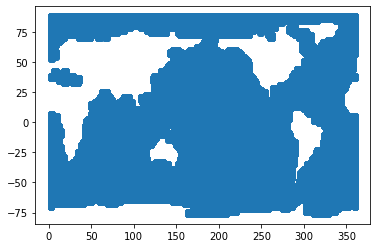

In [7]:
from matplotlib import pyplot as plt
plt.scatter(ulon[ocnmask], ulat[ocnmask])
plt.show()

In [8]:
#verify that the ticks are the same everywhere

ulon_ticks = tuple(ulon[0,:,0])
for i in range(ulon.shape[0]):
    for j in range(ulon.shape[2]):
        assert ulon_ticks == tuple(ulon[i,:,j])
#convert ulon to more standard indexing
#ulon_ticks = np.array(ulon_ticks)
#ulon_ticks = tuple(ulon_ticks*(ulon_ticks <= 180) + (-(360-ulon_ticks)*(ulon_ticks > 180)))
        
ulat_ticks = tuple(ulat[0,0,:])
for i in range(ulat.shape[0]):
    for j in range(ulat.shape[1]):
        assert ulat_ticks == tuple(ulat[i,j,:])
        
wz_ticks = tuple(wz[:,0,0])
for i in range(wz.shape[1]):
    for j in range(wz.shape[2]):
        assert wz_ticks == tuple(wz[:,i,j])

In [9]:
#Load the glodap data and sort observations into gridboxes
# based on where they fall w.r.t. the ticks

#Download the glodap data
#!wget https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0237935/GLODAPv2.2021_Pacific_Ocean.csv -O GLODAPv2.2021_Pacific_Ocean.csv
#!wget https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0237935/GLODAPv2.2021_Arctic_Ocean.csv -O GLODAPv2.2021_Arctic_Ocean.csv

In [79]:
import pandas

colnames_subset = ["G2latitude", 'G2longitude', 'G2year', 'G2depth',
                   'G2pressure', 'G2temperature','G2salinity','G2oxygen',
                   'G2silicate', 'G2nitrate', 'G2phosphate', 'G2sigma0']

pacific_df = pandas.read_csv("GLODAPv2.2021_Pacific_Ocean.csv",
                     na_values = -9999)[colnames_subset]

arctic_df = pandas.read_csv("GLODAPv2.2021_Arctic_Ocean.csv",
                     na_values = -9999)[colnames_subset]

glodap_df = pandas.concat([pacific_df, arctic_df], axis=0)

glodap_df.columns =["latitude", 'longitude', 'year', 'depth',
             'pressure', 'temperature','salinity','oxygen',
             'silicate', 'nitrate', 'phosphate', 'sigma0']                                     

glodap_df['potential_temp'] = gsw.pt_from_t(glodap_df['salinity'],
                                glodap_df['temperature'],
                                glodap_df['pressure'],
                                glodap_df['sigma0'])
glodap_df["absolute_salinity"] = gsw.SA_from_SP(
    SP=glodap_df["salinity"], p=glodap_df["pressure"],
    lon=glodap_df["longitude"], lat=glodap_df["latitude"])
glodap_df["conservative_temp"] = gsw.CT_from_t(SA=glodap_df["absolute_salinity"],
                                  t=glodap_df["temperature"],
                                  p=glodap_df["pressure"])
glodap_df["sigma2"] = gsw.sigma2(SA=glodap_df["absolute_salinity"],
                          CT=glodap_df["conservative_temp"])
glodap_df["sigma4"] = gsw.sigma4(SA=glodap_df["absolute_salinity"],
                          CT=glodap_df["conservative_temp"])

In [102]:
from collections import namedtuple


def initialize_grid(shape):
    grid = []
    for depth_idx in range(shape[0]):
        grid_depthentry = []
        for lon_idx in range(shape[1]):
            grid_lonentry = []
            for lat_idx in range(shape[2]):
                grid_latentry = []
                grid_lonentry.append(grid_latentry)
            grid_depthentry.append(grid_lonentry)
        grid.append(grid_depthentry)
    return grid


def prepare_obsgrid_from_df(df, wz_ticks, ulon_ticks, ulat_ticks,
                                depth_key, longitude_key, latitude_key):
    obs_grid = initialize_grid((len(wz_ticks), len(ulon_ticks), len(ulat_ticks)))
    
    orig_columns = df.columns
    df.columns = df.columns.str.replace(' ', '_')
    ObsEntry = namedtuple('ObsEntry', df.columns)
    
    for item in df.to_dict('records'):
        item_lon = item[longitude_key]
        item_lon = item_lon if item_lon > 0.0 else (360+item_lon)
        #the -1 is there because searchsorted will return the index
        # where the entry could be inserted, which is *after* the
        # tick corresponding to the gridbox you'd want to file it under
        lat_idx = np.searchsorted(ulat_ticks, item[latitude_key])-1
        lon_idx = np.searchsorted(ulon_ticks, item_lon)-1
        depth_idx = np.searchsorted(wz_ticks, item[depth_key])-1

        try:
            obs_grid[depth_idx][lon_idx][lat_idx].append(
                ObsEntry(**item))
        except:
            print(item[latitude_key], item_lon, item[depth_key])
            print(lat_idx, lon_idx, depth_idx)
    df.columns = orig_columns #go back to what it was
    return obs_grid


In [104]:
glodap_obs_grid = prepare_obsgrid_from_df(df=glodap_df,
    wz_ticks=wz_ticks, ulon_ticks=ulon_ticks, ulat_ticks=ulat_ticks,
    depth_key="depth", longitude_key="longitude", latitude_key="latitude")

In [84]:
#download GP15 data
import gp15wma
from importlib import reload
reload(gp15wma.funcdump)
reload(gp15wma)
from gp15wma import download_and_load_gp15_data

gp15wma.funcdump.download_gp15_data()
gp15_df = gp15wma.funcdump.load_gp15_data_unsplit()

--2021-11-02 22:44:13--  http://optserv1.whoi.edu/jgofsopt/80/128.12.123.170/GP15_Bottle_Leg1.mat
Resolving optserv1.whoi.edu (optserv1.whoi.edu)... 128.128.181.50
Connecting to optserv1.whoi.edu (optserv1.whoi.edu)|128.128.181.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 934504 (913K) [text/plain]
Saving to: ‘GP15_Bottle_Leg1.mat’

     0K .......... .......... .......... .......... ..........  5% 37.2K 23s
    50K .......... .......... .......... .......... .......... 10% 55.5K 18s
   100K .......... .......... .......... .......... .......... 16% 46.5K 17s
   150K .......... .......... .......... .......... .......... 21% 70.1K 14s
   200K .......... .......... .......... .......... .......... 27% 93.2K 12s
   250K .......... .......... .......... .......... .......... 32% 69.8K 11s
   300K .......... .......... .......... .......... .......... 38% 69.5K 10s
   350K .......... .......... .......... .......... .......... 43% 69.6K 9s
   400K .......... 

bottle flag BTLNBR_FLAG_W BTLNBR_FLAG_W
uint8
leg1 nans 0
leg2 nans 0
CTD salinity flag CTDSAL_FLAG_W CTDSAL_FLAG_W
uint8
leg1 nans 0
leg2 nans 0
bottle oxygen flag Flag_OXYGEN_D_CONC_BOTTLE_qizf9x Flag_OXYGEN_D_CONC_BOTTLE_n41f8b
uint8
leg1 nans 0
leg2 nans 0
silicate flag Flag_SILICATE_D_CONC_BOTTLE_l9fh07 Flag_SILICATE_D_CONC_BOTTLE_3fot83
uint8
leg1 nans 0
leg2 nans 0
nitrate flag Flag_NITRATE_D_CONC_BOTTLE_xhgtuv Flag_NITRATE_D_CONC_BOTTLE_bugat8
uint8
leg1 nans 0
leg2 nans 0
phosphate flag Flag_PHOSPHATE_D_CONC_BOTTLE_lof4ap Flag_PHOSPHATE_D_CONC_BOTTLE_d0rgav
uint8
leg1 nans 0
leg2 nans 0
CTD pressure CTDPRS CTDPRS
float64
leg1 nans 487
leg2 nans 492
CTD temperature CTDTMP CTDTMP
float64
leg1 nans 487
leg2 nans 492
practical_salinity CTDSAL CTDSAL
float64
leg1 nans 487
leg2 nans 492
lat LATITUDE LATITUDE
float64
leg1 nans 476
leg2 nans 484
lon LONGITUDE LONGITUDE
float64
leg1 nans 476
leg2 nans 484
stnnbr STNNBR STNNBR
<U12
leg1 and leg2 arrays are strings.
geotrc_ID GEOTRC_SAMP

 .......... 99%  112K 0s
  1100K ........                                              100% 97.5K=19s

2021-11-02 22:44:46 (57.3 KB/s) - ‘GP15_Bottle_Leg2.mat’ saved [1135288/1135288]



In [103]:
gp15_obs_grid = prepare_obsgrid_from_df(df=gp15_df,
    wz_ticks=wz_ticks, ulon_ticks=ulon_ticks, ulat_ticks=ulat_ticks,
    depth_key="Depth", longitude_key="lon", latitude_key="lat")

In [105]:
#for conservative temp and absolute salinity, create a glodap-derived
# mean grid

def get_data_from_obs_grid(func, obs_grid):
    to_return = np.zeros(
        (len(obs_grid), len(obs_grid[0]),
         len(obs_grid[0][0])) )
    to_return[:,:,:] = np.nan
    for i in range(len(obs_grid)):
        for j in range(len(obs_grid[i])):
            for k in range(len(obs_grid[i][j])):
                if len(obs_grid[i][j][k]) > 0:
                    to_return[i,j,k] = func(obs_grid[i][j][k])
    return to_return

glodap_mean_abssal = get_data_from_obs_grid(
    func=lambda x: np.mean([y.absolute_salinity for y in x]),
    obs_grid=glodap_obs_grid)
glodap_mean_constemp = get_data_from_obs_grid(
    func=lambda x: np.mean([y.conservative_temp for y in x]),
    obs_grid=glodap_obs_grid)
glodap_mean_silicate = get_data_from_obs_grid(
    func=lambda x: np.mean([y.silicate for y in x]),
    obs_grid=glodap_obs_grid)
glodap_numobs = get_data_from_obs_grid(
    func=lambda x: len(x),
    obs_grid=glodap_obs_grid)

gp15_mean_silicate = get_data_from_obs_grid(
    func=lambda x: np.mean([y.silicate for y in x]),
    obs_grid=gp15_obs_grid)


In [13]:
ulat_ocnvec = ulat.ravel()[ocnmask.ravel()]
ulon_ocnvec = ulon.ravel()[ocnmask.ravel()]
#convert ulon to have negative longitudes
ulon_ocnvec = ulon_ocnvec*(ulon_ocnvec <= 180) + (-(360-ulon_ocnvec)*(ulon_ocnvec > 180))

depth_ocnvec = wz.ravel()[ocnmask.ravel()]

#z is expected to be negative in the ocean
#gives pressure in dbar
#removing geo_strf_dyn_height still gives stuff
# that's pretty correlated
p_ocnvec = gsw.p_from_z(
    z=-depth_ocnvec,
    lat=ulat_ocnvec,
    geo_strf_dyn_height=np.tile(ssh[None,:,:], (48,1,1)).ravel()[ocnmask.ravel()])

#absolute salinity
absal_ocnvec = gsw.SA_from_SP(
    SP=salt.ravel()[ocnmask.ravel()],
    p=p_ocnvec,
    lon=ulon_ocnvec,
    lat=ulat_ocnvec)

ctemp_ocnvec = gsw.CT_from_pt(
    SA=absal_ocnvec,
    pt=ptemp.ravel()[ocnmask.ravel()]) #assumes 0 dbar for pt

sig0_ocnvec = gsw.sigma0(SA=absal_ocnvec,CT=ctemp_ocnvec)
sig2_ocnvec = gsw.sigma2(SA=absal_ocnvec,CT=ctemp_ocnvec)
sig4_ocnvec = gsw.sigma4(SA=absal_ocnvec,CT=ctemp_ocnvec)


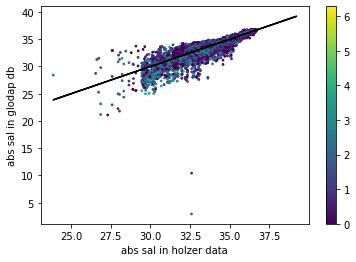

In [14]:
plt.scatter(absal_ocnvec,
            glodap_mean_abssal.ravel()[ocnmask.ravel()],
            s=3, c=np.log(glodap_numobs.ravel()[ocnmask.ravel()]),
            alpha=1)
plt.colorbar()
plt.plot(absal_ocnvec, absal_ocnvec, color="black")
plt.xlabel("abs sal in holzer data")
plt.ylabel("abs sal in glodap db")
plt.show()

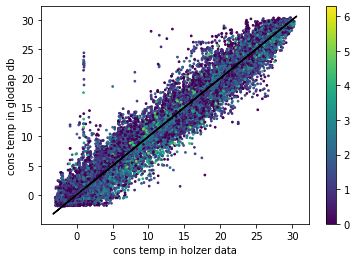

In [15]:
plt.scatter(ctemp_ocnvec,
            glodap_mean_constemp.ravel()[ocnmask.ravel()],
            s=3, c=np.log(glodap_numobs.ravel()[ocnmask.ravel()]),
            alpha=1)
plt.colorbar()
plt.plot(ctemp_ocnvec, ctemp_ocnvec, color="black")
plt.xlabel("cons temp in holzer data")
plt.ylabel("cons temp in glodap db")
plt.show()

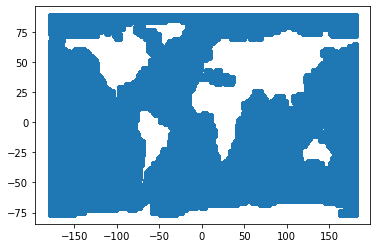

In [16]:
from matplotlib import pyplot as plt
plt.scatter(ulon_ocnvec, ulat_ocnvec)

In [17]:
#copying filter conditions from
# https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/8aba68bf38940ffa7bc84afd7cedc5ac4380ecd2/GP15_Defining_Watermass_Subtypes.ipynb#scrollTo=h5hNQdcE2tnn

def get_nonzero_idxs(lat_min, lat_max,
                     lon_min, lon_max,
                     sig0_min=0, sig0_max=np.inf, 
                     sig2_min=0, sig2_max=np.inf,
                     sig4_min=0, sig4_max=np.inf):
    
    #need to subtract 180 cos ulon_ocnvec goes from 0 to 360
    nonzero_idxs = np.nonzero(
        (ulat_ocnvec >= lat_min)*(ulat_ocnvec <= lat_max)
       *((ulon_ocnvec) >= lon_min)*((ulon_ocnvec) <= lon_max)
       *(sig0_ocnvec >= sig0_min)*(sig0_ocnvec <= sig0_max)
       *(sig2_ocnvec >= sig2_min)*(sig2_ocnvec <= sig2_max)
       *(sig4_ocnvec >= sig4_min)*(sig4_ocnvec <= sig4_max)
    )[0]
    
    return nonzero_idxs

filter_conditions = {
    "AAIW": {"lat_min":-55.0, "lat_max":-43.0,
             "lon_min":-90, "lon_max":-80,
             "sig0_min":27.05, "sig0_max":27.15},
    "NPIW": {"lat_min":34.0, "lat_max":37.0, 
             "lon_min":140.0, "lon_max":153.0, 
             "sig0_min":26.5, "sig0_max":27.4, 
             #"ox_min":0, "ox_max":150.0, #TODO: think about this
             },
    "UCDW": {"lat_min":-49.5, "lat_max":-44.5, 
             "lon_min":-157.0, "lon_max":-147.0,
             "sig0_min":27.35, "sig0_max":27.75,
             },
    "LCDW": {"lat_min":-66.5, "lat_max":-61.5, 
             "lon_min":-100.0, "lon_max":150.0,
             "sig0_min":27.79, "sig0_max":27.83,
             },
    "AABW": {"lat_min":-66.5, "lat_max":-61.5, 
             "lon_min":-100.0, "lon_max":150.0,
             "sig4_min":46.04, "sig4_max":200,
             },
    "PDW": {"lat_min":39.0, "lat_max":51.0, 
             "lon_min":-170.0, "lon_max":-133.0,
             "sig0_min":27.6, "sig0_max":200,
             "sig4_min":0, "sig4_max":45.88,
            },
    "EqIW": {"lat_min":-5, "lat_max":5, 
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 26.86, "sig0_max": 27.3,
             },
    "PSUW": {"lat_min":50, "lat_max":58, 
             "lon_min":-155, "lon_max":-140,
             "sig0_min": 25.29, "sig0_max": 26.86,
             },
    "ENPCW": {"lat_min":16, "lat_max":26, 
              "lon_min":-170, "lon_max":-140,
              "sig0_min": 25.29, "sig0_max": 26.86,
              },
    "ESSW": {"lat_min":-5, "lat_max":5, 
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 25.29, "sig0_max": 26.86,
             },
    "SPCW": {"lat_min":-30, "lat_max":-20, 
             "lon_min":-152, "lon_max":-130, 
             "sig0_min": 25.29, "sig0_max": 26.86,
             },
    "SPSTSW": {"lat_min":-20, "lat_max":-15, 
               "lon_min":-152, "lon_max":-142, 
               "sig0_min": 25.29, "sig0_max": 26.86,
              }
}

endmem_to_nonzeroidxs = dict([(the_key, set(get_nonzero_idxs(**val)))
                              for the_key,val in filter_conditions.items()])

starting init
ending init
convergence sum: 2559.6647641918657
convergence max: 0.0382436091207623
1000
Time: 5.730281114578247 s


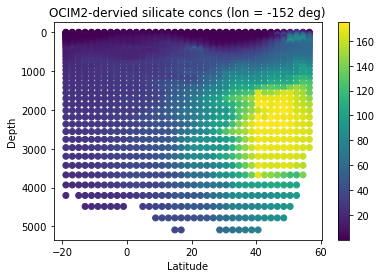

convergence sum: 1362.5885913466234
convergence max: 0.021673708872860686
2000
Time: 11.904510974884033 s


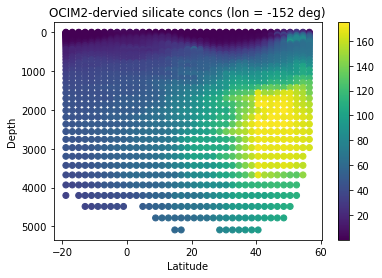

convergence sum: 794.1364292383629
convergence max: 0.011275531433199149
3000
Time: 17.692716121673584 s


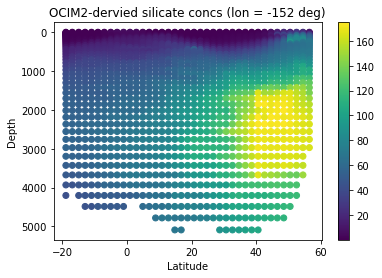

convergence sum: 490.13452870360067
convergence max: 0.00592180228048278
4000
Time: 24.559149026870728 s


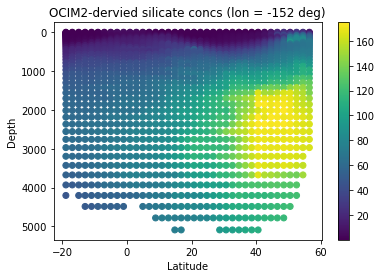

convergence sum: 321.7381603296969
convergence max: 0.004868870290447802
5000
Time: 31.6263370513916 s


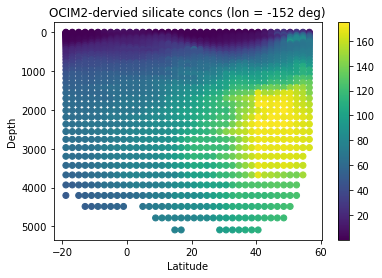

convergence sum: 226.2898463549552
convergence max: 0.004626093700522915
6000
Time: 38.434199810028076 s


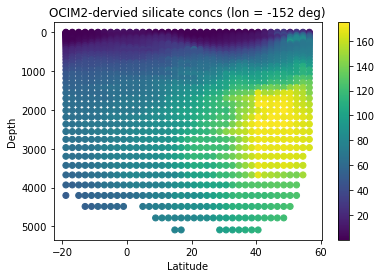

convergence sum: 171.1432270337
convergence max: 0.004439100613577551
7000
Time: 45.2434561252594 s


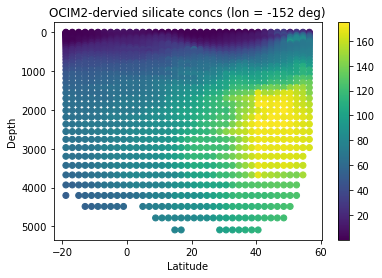

convergence sum: 138.6649236963614
convergence max: 0.00417157205240315
8000
Time: 52.00060200691223 s


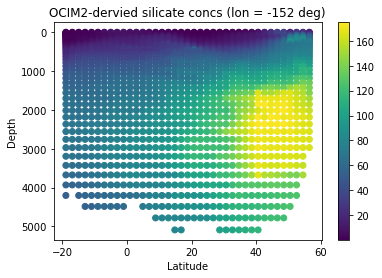

convergence sum: 119.10257161713557
convergence max: 0.00385089541537198
9000
Time: 58.8573899269104 s


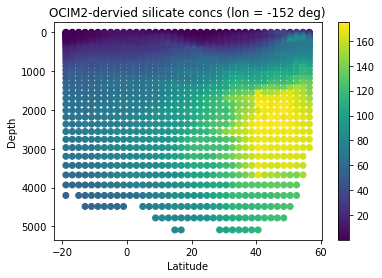

convergence sum: 106.97393265860438
convergence max: 0.0035231854118507044
10000
Time: 65.71760702133179 s


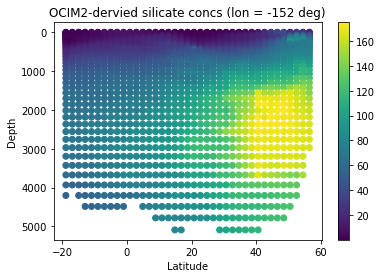

array([  0.35998446,   0.73914239,   1.38226541, ..., 110.51873313,
       112.70476002, 115.03773694])

In [25]:
import scipy.sparse
from collections import OrderedDict
import time


class GetSteadyStateTracerConcsViaIteration(object):
    
    def __init__(self, base_transition_prob_mat, source_idxs, global_tracer_vec):
            
        print("starting init")
        self.trmat, self.initvec = self.get_trmat_and_initvec_for_endmem(
                            base_transition_prob_mat=base_transition_prob_mat,
                            source_idxs=source_idxs,
                            global_tracer_vec=global_tracer_vec)
        print("ending init")
        self.lateststatevec = self.initvec
        self.total_timesteps = 0
        self.diff_from_prev = None
        
    @staticmethod
    def get_trmat_and_initvec_for_endmem(base_transition_prob_mat,
                                         source_idxs,
                                         global_tracer_vec):
        rows_to_zeroout = np.ones(base_transition_prob_mat.shape[0])
        for idx in source_idxs:
            if (np.isnan(global_tracer_vec[idx])==False):
                rows_to_zeroout[idx] = 0.0
            #else:
            #    print("No observations for idx",idx,
            #          "treating it as target")
        rowzerod_trprobmat = scipy.sparse.diags(rows_to_zeroout) @ base_transition_prob_mat
        new_rowzerod_trprobmat = rowzerod_trprobmat.tolil()
        init_label_vec = np.zeros(rowzerod_trprobmat.shape[0])
        for idx in source_idxs:
            if (np.isnan(global_tracer_vec[idx])==False):
                new_rowzerod_trprobmat[idx,idx] = 1.0
                init_label_vec[idx] = global_tracer_vec[idx]
        new_rowzerod_trprobmat = new_rowzerod_trprobmat.tocsc()
        return new_rowzerod_trprobmat, init_label_vec
    
    def take_step(self, num_timesteps=1):
        for i in range(num_timesteps):
            oldvec = self.lateststatevec
            self.lateststatevec = (self.trmat @ self.lateststatevec)
            self.diff_from_prev = self.lateststatevec - oldvec
            self.total_timesteps += 1
        print("convergence sum:",np.sum(np.abs(self.diff_from_prev)))
        print("convergence max:",np.max(np.abs(self.diff_from_prev)))
        
    
silicate_concs = GetSteadyStateTracerConcsViaIteration(
    base_transition_prob_mat=transition_prob_mat,
    source_idxs=np.concatenate([list(x) for x in endmem_to_nonzeroidxs.values()],
                               axis=0),
    global_tracer_vec=glodap_mean_silicate.ravel()[ocnmask.ravel()]
    )


start = time.time()
for i in range(10):
    silicate_concs.take_step(num_timesteps=1000)
    print(silicate_concs.total_timesteps)
    print("Time:", time.time()-start,"s")
    plt.scatter(
        ulat_ocnvec[gp15_idxs],
        depth_ocnvec[gp15_idxs],
        c=silicate_concs.lateststatevec[gp15_idxs],
        #vmin=0.0, vmax=1.0
    )
    plt.ylim(plt.ylim()[1], plt.ylim()[0])
    plt.ylabel("Depth")
    plt.xlabel("Latitude")
    plt.title("OCIM2-dervied silicate concs (lon = -152 deg)")
    plt.colorbar()
    plt.show()

silicate_concs.lateststatevec[gp15_idxs]

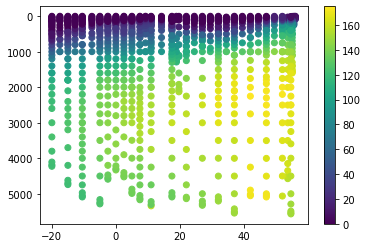

In [77]:
plt.scatter(gp15_df['lat'], gp15_df['Depth'], c=gp15_df['silicate'])
plt.colorbar()
plt.ylim(plt.ylim()[1], plt.ylim()[0])
plt.show()

In [110]:
#get the cells corresponding to the gp15 cruise
gp15_idxs = np.nonzero((np.isnan(gp15_mean_silicate)==False).ravel()[ocnmask.ravel()])


#gp15_idxs = get_nonzero_idxs(lon_min=-152, lon_max=-152, lat_min=-20, lat_max=60)

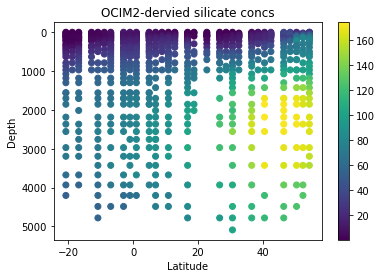

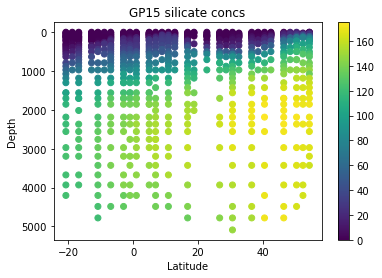

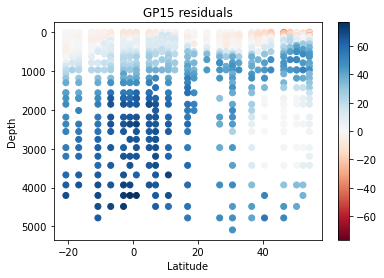

In [116]:
plt.scatter(
    ulat_ocnvec[gp15_idxs],
    depth_ocnvec[gp15_idxs],
    c=silicate_concs.lateststatevec[gp15_idxs],
    #vmin=0.0, vmax=1.0
)
plt.ylim(plt.ylim()[1], plt.ylim()[0])
plt.ylabel("Depth")
plt.xlabel("Latitude")
plt.title("OCIM2-dervied silicate concs")
plt.colorbar()
plt.show()

plt.scatter(
    ulat_ocnvec[gp15_idxs],
    depth_ocnvec[gp15_idxs],
    c=gp15_mean_silicate.ravel()[ocnmask.ravel()][gp15_idxs],
    #vmin=0.0, vmax=1.0
)
plt.ylim(plt.ylim()[1], plt.ylim()[0])
plt.ylabel("Depth")
plt.xlabel("Latitude")
plt.title("GP15 silicate concs")
plt.colorbar()
plt.show()

gp15_silicate_resids = (gp15_mean_silicate.ravel()[ocnmask.ravel()][gp15_idxs]
                        - silicate_concs.lateststatevec[gp15_idxs])
plt.scatter(
    ulat_ocnvec[gp15_idxs],
    depth_ocnvec[gp15_idxs],
    c=gp15_silicate_resids,
    vmin=-np.max(np.abs(gp15_silicate_resids)),
    vmax=np.max(np.abs(gp15_silicate_resids)),
    cmap="RdBu"
)
plt.ylim(plt.ylim()[1], plt.ylim()[0])
plt.ylabel("Depth")
plt.xlabel("Latitude")
plt.title("GP15 residuals")
plt.colorbar()
plt.show()